In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
import torch
torch.cuda.device_count()

1

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
# import wandb

import monai
from monai.losses import DiceCELoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai import transforms

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    MapTransform,
    ScaleIntensityd,
    AddChanneld,
    SpatialPadd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    ConcatItemsd,
    AdjustContrastd, 
    Rand3DElasticd,
    HistogramNormalized,
    NormalizeIntensityd,
    Invertd,
    SaveImage,

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNETR, SegResNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai import data


from monai.utils import first, set_determinism
from sklearn.model_selection import train_test_split
import json


import torch

/home/ikboljonsobirov/.conda/envs/sega/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_determinism(seed=1024)


In [3]:
data_dir = '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/'
json_dir = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/files/train_json_new.json'

In [4]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [5]:
train_files, validation_files = datafold_read(datalist=json_dir, basedir=data_dir, fold=0)
len(train_files), len(validation_files)

(419, 105)

/home/ikboljonsobirov/.conda/envs/sega/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.array LoadImage.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


torch.Size([1, 200, 200, 310])


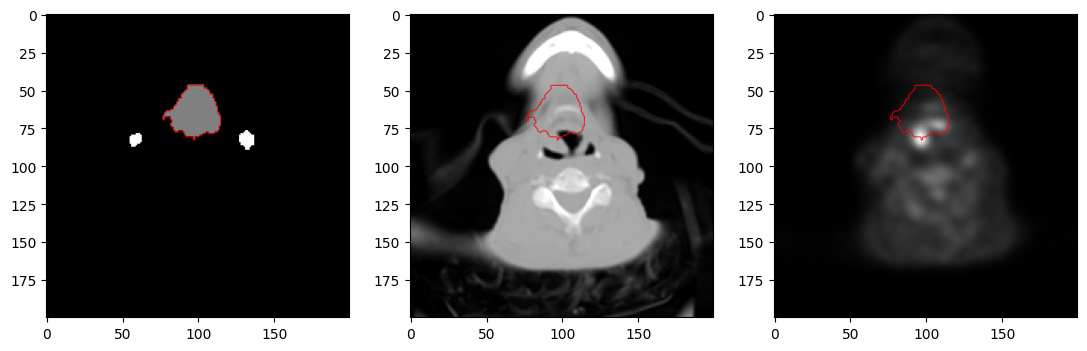

In [7]:
from skimage import measure

gt = monai.transforms.LoadImage(ensure_channel_first=True)('/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/CHUS-081/CHUS-081_gt.nii.gz')
plt.figure("image", (18, 10))
gt = monai.transforms.Orientation(axcodes='PLS')(gt[0])
plt.subplot(2, 4, 1)
plt.imshow(gt[0,:,:,118], cmap='gray')
print(gt.shape)

contours = measure.find_contours(gt[0,:,:,118], 0.5)[0]
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/CHUV-002/CHUV-002_ct.nii.gz')
ct = monai.transforms.Orientation(axcodes='PLS')(ct[0])
ct = torch.clip(ct, min=-1000, max=600)
plt.subplot(2, 4, 2)
plt.imshow(ct[0,:,:,118], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

pt = monai.transforms.LoadImage(ensure_channel_first=True)('/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/CHUV-002/CHUV-002_pt.nii.gz')
pt = monai.transforms.Orientation(axcodes='PLS')(pt[0])
plt.subplot(2, 4, 3)
plt.imshow(pt[0,:,:,118], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)


In [6]:
class ClipCT(MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            # elif key == "pt":
            #     d[key] = torch.clip(d[key], d[key].min(), 5)
        return d
class MulPTFM(MapTransform):
    """
    Mult PT and FM 

    """

    def __call__(self, data):
        d = dict(data)

        fm = d["ct"] > 0
        d["pt"] = d["pt"] * fm
        return d
class SelectClass(MapTransform):
    """
    Select the class for which you want to fine tune the model 

    """
    # def __init__(self, keys, cls=1):
    #     super(self).__init__(keys)
    #     self.cls = cls

    def __call__(self, data):
        d = dict(data)
        d["seg"][d["seg"] == 1] = 0
        # d["seg"][d["seg"] == 2] = 1
        
        return d

In [7]:
num_samples = 4

train_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        #NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["ctpt", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="ctpt",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[0],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[1],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[2],
            prob=0.20,
        ),
        RandRotate90d(
            keys=["ctpt", "seg"],
            prob=0.20,
            max_k=3,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    ]
)

/home/ikboljonsobirov/.conda/envs/sega/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


[{'id': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/CHUV-002',
  'fold': 1,
  'ct': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/CHUV-002/CHUV-002_ct.nii.gz',
  'pt': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/CHUV-002/CHUV-002_pt.nii.gz',
  'seg': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/CHUV-002/CHUV-002_gt.nii.gz'},
 {'id': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/MDA-146',
  'fold': 1,
  'ct': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/MDA-146/MDA-146_ct.nii.gz',
  'pt': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/MDA-146/MDA-146_pt.nii.gz',
  'seg': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/MDA-146/MDA-146_gt.nii.gz'},
 {'id': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/CHUS-081',
  'fold': 1,
  'ct': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/CHUS-081/CHUS-081_ct.nii.gz',
 

: 

In [10]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=6,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
    )

val_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)

val_loader = DataLoader(
    val_ds, 
    batch_size=2, 
    num_workers=8, 
    shuffle= False)

In [11]:
a = next(iter(train_loader))

In [12]:
a['ct'].shape

torch.Size([24, 1, 200, 200, 310])

In [13]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegResNet(in_channels=2, 
                  out_channels=3, 
                  init_filters=16).to(device)

# model = UNETR(
#     in_channels=2,
#     out_channels=3,
#     img_size=(96, 96, 96),
#     feature_size=16,
#     hidden_size=768,
#     mlp_dim=3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.0,
# ).to(device)

# model = SwinUNETR(img_size= (96, 96, 96),
#                   in_channels=2,
#                   out_channels=3,
#                   depths = (2, 2, 2, 2),
#                   num_heads = (3, 6, 12, 24),
#                   feature_size = 24,
#                   norm_name = "instance",
#                   drop_rate = 0.0,
#                 attn_drop_rate = 0.0,
#                 dropout_path_rate = 0.0,
#                 normalize = True,
#                 use_checkpoint = False,
#                 spatial_dims = 3,
#                 downsample="merging").to(device)

In [14]:
torch.backends.cudnn.benchmark = True
def poly_lr(epoch, max_epochs, initial_lr, exponent=0.9):
    return initial_lr * (1 - epoch / max_epochs)**exponent

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [15]:
model_dir = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/files/'

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["ctpt"].cuda(), batch["seg"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()
    return mean_dice_val, metric_tumor, metric_lymph


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["ctpt"].cuda(), batch["seg"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val, metric_tumor, metric_lymph = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            metric_values_tumor.append(metric_tumor)
            metric_values_lymph.append(metric_lymph)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(model_dir, "best_metric_segresnet.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val, metric_tumor, metric_lymph
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val,  metric_tumor, metric_lymph
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 18000
eval_num = 100

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

epoch = 0
max_num_epochs = 530

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
metric_values_tumor = []
metric_values_lymph = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
    # wandb.log({'learning_rate': optimizer.param_groups[0]['lr']})
    # wandb.log({'Best Dice': dice_val_best})
    epoch += 1
    #optimizer.param_groups[0]['lr'] = poly_lr(epoch, max_num_epochs, 0.005676 , 0.9)
# model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_luck_UNETr_prompt.pth")))

Training (100 / 18000 Steps) (loss=1.53861):  44%|████▍     | 31/70 [02:38<14:39, 22.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.18639111518859863 Current Avg. Dice: 0.18639111518859863 Current Avg. tumor Dice: 0.33429428935050964 Current Avg. lymph Dice: 0.002133453032001853


Training (200 / 18000 Steps) (loss=1.42789):  87%|████████▋ | 61/70 [03:42<03:07, 20.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2844836711883545 Current Avg. Dice: 0.2844836711883545 Current Avg. tumor Dice: 0.4008009433746338 Current Avg. lymph Dice: 0.1313193142414093


Training (300 / 18000 Steps) (loss=1.32407):  30%|███       | 21/70 [02:15<17:42, 21.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3257225453853607 Current Avg. Dice: 0.3257225453853607 Current Avg. tumor Dice: 0.4454866647720337 Current Avg. lymph Dice: 0.158156618475914


Training (400 / 18000 Steps) (loss=1.23485):  73%|███████▎  | 51/70 [03:21<06:57, 21.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3257225453853607 Current Avg. Dice: 0.23054718971252441 Current Avg. tumor Dice: 0.36115697026252747 Current Avg. lymph Dice: 0.06416412442922592


Training (500 / 18000 Steps) (loss=1.15436):  16%|█▌        | 11/70 [01:52<22:42, 23.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3257225453853607 Current Avg. Dice: 0.31162509322166443 Current Avg. tumor Dice: 0.46519649028778076 Current Avg. lymph Dice: 0.09790821373462677


Training (600 / 18000 Steps) (loss=1.07371):  59%|█████▊    | 41/70 [03:02<11:37, 24.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.3725827932357788 Current Avg. tumor Dice: 0.5049970746040344 Current Avg. lymph Dice: 0.1950518637895584


Training (700 / 18000 Steps) (loss=1.00970):   1%|▏         | 1/70 [01:30<1:44:23, 90.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.3651907742023468 Current Avg. tumor Dice: 0.5438966155052185 Current Avg. lymph Dice: 0.13404688239097595


Training (800 / 18000 Steps) (loss=0.95901):  44%|████▍     | 31/70 [02:33<13:58, 21.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.3196777403354645 Current Avg. tumor Dice: 0.574520468711853 Current Avg. lymph Dice: 0.0004476044268812984


Training (900 / 18000 Steps) (loss=0.91476):  87%|████████▋ | 61/70 [03:42<03:09, 21.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.32705527544021606 Current Avg. tumor Dice: 0.5872546434402466 Current Avg. lymph Dice: 0.0


Training (1000 / 18000 Steps) (loss=0.87106):  30%|███       | 21/70 [02:14<17:54, 21.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.29520928859710693 Current Avg. tumor Dice: 0.5303450226783752 Current Avg. lymph Dice: 0.0


Training (1100 / 18000 Steps) (loss=0.85940):  73%|███████▎  | 51/70 [03:20<07:04, 22.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.10163900256156921 Current Avg. tumor Dice: 0.19333498179912567 Current Avg. lymph Dice: 0.0


Training (1200 / 18000 Steps) (loss=0.82290):  16%|█▌        | 11/70 [01:52<22:38, 23.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.11020979285240173 Current Avg. tumor Dice: 0.20284177362918854 Current Avg. lymph Dice: 0.0


Training (1300 / 18000 Steps) (loss=0.80199):  59%|█████▊    | 41/70 [03:04<11:22, 23.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.06459684669971466 Current Avg. tumor Dice: 0.11776809394359589 Current Avg. lymph Dice: 0.0


Training (1400 / 18000 Steps) (loss=0.78737):   1%|▏         | 1/70 [01:29<1:43:05, 89.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.08370646834373474 Current Avg. tumor Dice: 0.15267442166805267 Current Avg. lymph Dice: 0.0


Training (1500 / 18000 Steps) (loss=0.76300):  44%|████▍     | 31/70 [02:31<13:59, 21.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.06678561866283417 Current Avg. tumor Dice: 0.12003038078546524 Current Avg. lymph Dice: 0.0


Training (1600 / 18000 Steps) (loss=0.72744):  87%|████████▋ | 61/70 [03:42<03:09, 21.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.028405169025063515 Current Avg. tumor Dice: 0.054672565311193466 Current Avg. lymph Dice: 0.0


Training (1700 / 18000 Steps) (loss=0.73327):  30%|███       | 21/70 [02:15<17:44, 21.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.031143944710493088 Current Avg. tumor Dice: 0.05590203404426575 Current Avg. lymph Dice: 0.0


Training (1800 / 18000 Steps) (loss=0.71631):  73%|███████▎  | 51/70 [03:24<07:06, 22.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.01292020920664072 Current Avg. tumor Dice: 0.023836588487029076 Current Avg. lymph Dice: 0.0


Training (1900 / 18000 Steps) (loss=0.72013):  16%|█▌        | 11/70 [01:51<22:30, 22.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.10403827577829361 Current Avg. tumor Dice: 0.1765121966600418 Current Avg. lymph Dice: 0.0


Training (2000 / 18000 Steps) (loss=0.69692):  59%|█████▊    | 41/70 [03:04<11:20, 23.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.030755143612623215 Current Avg. tumor Dice: 0.05293785035610199 Current Avg. lymph Dice: 0.0


Training (2100 / 18000 Steps) (loss=0.67167):   1%|▏         | 1/70 [01:27<1:40:36, 87.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.11195812374353409 Current Avg. tumor Dice: 0.19907253980636597 Current Avg. lymph Dice: 0.0


Training (2200 / 18000 Steps) (loss=0.67870):  44%|████▍     | 31/70 [02:34<14:00, 21.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.065656878054142 Current Avg. tumor Dice: 0.11300945281982422 Current Avg. lymph Dice: 0.0


Training (2300 / 18000 Steps) (loss=0.67293):  87%|████████▋ | 61/70 [03:42<03:06, 20.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.04129737615585327 Current Avg. tumor Dice: 0.0730084776878357 Current Avg. lymph Dice: 0.0


Training (2400 / 18000 Steps) (loss=0.67327):  30%|███       | 21/70 [02:15<17:45, 21.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.020055456086993217 Current Avg. tumor Dice: 0.03431299701333046 Current Avg. lymph Dice: 0.0


Training (2500 / 18000 Steps) (loss=0.64715):  73%|███████▎  | 51/70 [03:24<06:56, 21.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.07313568890094757 Current Avg. tumor Dice: 0.12267006188631058 Current Avg. lymph Dice: 0.0


Training (2600 / 18000 Steps) (loss=0.62955):  16%|█▌        | 11/70 [01:53<23:00, 23.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.04335412010550499 Current Avg. tumor Dice: 0.07542623579502106 Current Avg. lymph Dice: 0.0


Training (2700 / 18000 Steps) (loss=0.65690):  59%|█████▊    | 41/70 [02:57<10:42, 22.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.09457102417945862 Current Avg. tumor Dice: 0.16150017082691193 Current Avg. lymph Dice: 0.0


Training (2800 / 18000 Steps) (loss=0.64217):   1%|▏         | 1/70 [01:28<1:41:52, 88.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.008808155544102192 Current Avg. tumor Dice: 0.013894299045205116 Current Avg. lymph Dice: 0.0


Training (2900 / 18000 Steps) (loss=0.64382):  44%|████▍     | 31/70 [02:36<13:56, 21.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.059878282248973846 Current Avg. tumor Dice: 0.09845606982707977 Current Avg. lymph Dice: 0.0


Training (3000 / 18000 Steps) (loss=0.62328):  87%|████████▋ | 61/70 [03:43<03:11, 21.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.033365294337272644 Current Avg. tumor Dice: 0.05338432267308235 Current Avg. lymph Dice: 0.0


Training (3100 / 18000 Steps) (loss=0.63477):  30%|███       | 21/70 [02:10<17:57, 21.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.23642498254776 Current Avg. tumor Dice: 0.42136555910110474 Current Avg. lymph Dice: 0.0


Training (3200 / 18000 Steps) (loss=0.63204):  73%|███████▎  | 51/70 [03:24<07:01, 22.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.003945916425436735 Current Avg. tumor Dice: 0.006437315139919519 Current Avg. lymph Dice: 0.0


Training (3300 / 18000 Steps) (loss=0.61790):  16%|█▌        | 11/70 [01:52<23:02, 23.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.009518890641629696 Current Avg. tumor Dice: 0.012279744260013103 Current Avg. lymph Dice: 0.0


Training (3400 / 18000 Steps) (loss=0.60298):  59%|█████▊    | 41/70 [03:00<11:10, 23.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.003902115160599351 Current Avg. tumor Dice: 0.006049903109669685 Current Avg. lymph Dice: 0.0


Training (3500 / 18000 Steps) (loss=0.63245):   1%|▏         | 1/70 [01:30<1:43:49, 90.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 9.764462447492406e-06 Current Avg. tumor Dice: 2.0505371139734052e-05 Current Avg. lymph Dice: 0.0


Training (3600 / 18000 Steps) (loss=0.59596):  44%|████▍     | 31/70 [02:33<14:01, 21.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.004117462318390608 Current Avg. tumor Dice: 0.005491933319717646 Current Avg. lymph Dice: 0.0


Training (3700 / 18000 Steps) (loss=0.61960):  87%|████████▋ | 61/70 [03:43<03:10, 21.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.0027583977207541466 Current Avg. tumor Dice: 0.005729551427066326 Current Avg. lymph Dice: 0.0


Training (3800 / 18000 Steps) (loss=0.57504):  30%|███       | 21/70 [02:13<17:21, 21.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.00015992265252862126 Current Avg. tumor Dice: 0.00033583759795874357 Current Avg. lymph Dice: 0.0


Training (3900 / 18000 Steps) (loss=0.52358):  73%|███████▎  | 51/70 [03:24<07:01, 22.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3725827932357788 Current Avg. Dice: 0.20905834436416626 Current Avg. tumor Dice: 0.01021950040012598 Current Avg. lymph Dice: 0.4691240191459656


Training (4000 / 18000 Steps) (loss=0.52838):  16%|█▌        | 11/70 [01:54<22:41, 23.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6016267538070679 Current Avg. Dice: 0.6016267538070679 Current Avg. tumor Dice: 0.6645469069480896 Current Avg. lymph Dice: 0.5293018817901611


Training (4100 / 18000 Steps) (loss=0.58800):  59%|█████▊    | 41/70 [03:00<10:59, 22.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6016267538070679 Current Avg. Dice: 0.5778861045837402 Current Avg. tumor Dice: 0.5965768694877625 Current Avg. lymph Dice: 0.5529966354370117


Training (4200 / 18000 Steps) (loss=0.53741):   1%|▏         | 1/70 [01:31<1:44:46, 91.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6016267538070679 Current Avg. Dice: 0.5962068438529968 Current Avg. tumor Dice: 0.6368990540504456 Current Avg. lymph Dice: 0.5388972163200378


Training (4300 / 18000 Steps) (loss=0.36312):  44%|████▍     | 31/70 [02:33<14:03, 21.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6068189144134521 Current Avg. Dice: 0.6068189144134521 Current Avg. tumor Dice: 0.6688659191131592 Current Avg. lymph Dice: 0.5320191383361816


Training (4400 / 18000 Steps) (loss=0.51745):  87%|████████▋ | 61/70 [03:42<03:10, 21.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6068189144134521 Current Avg. Dice: 0.5961591601371765 Current Avg. tumor Dice: 0.6257675886154175 Current Avg. lymph Dice: 0.5571416616439819


Training (4500 / 18000 Steps) (loss=0.43748):  30%|███       | 21/70 [02:13<17:51, 21.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.618420422077179 Current Avg. Dice: 0.618420422077179 Current Avg. tumor Dice: 0.6724207997322083 Current Avg. lymph Dice: 0.5536898970603943


Training (4600 / 18000 Steps) (loss=0.42671):  73%|███████▎  | 51/70 [03:25<07:16, 22.96s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6192060112953186 Current Avg. Dice: 0.6192060112953186 Current Avg. tumor Dice: 0.6719438433647156 Current Avg. lymph Dice: 0.5578981041908264


Training (4700 / 18000 Steps) (loss=0.47262):  16%|█▌        | 11/70 [01:52<22:39, 23.04s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6245338320732117 Current Avg. Dice: 0.6245338320732117 Current Avg. tumor Dice: 0.6756025552749634 Current Avg. lymph Dice: 0.5654881000518799


Training (4800 / 18000 Steps) (loss=0.46885):  59%|█████▊    | 41/70 [03:04<11:21, 23.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6245338320732117 Current Avg. Dice: 0.6170385479927063 Current Avg. tumor Dice: 0.6667508482933044 Current Avg. lymph Dice: 0.5651973485946655


Training (4900 / 18000 Steps) (loss=0.51763):   1%|▏         | 1/70 [01:28<1:42:01, 88.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6245338320732117 Current Avg. Dice: 0.6156195998191833 Current Avg. tumor Dice: 0.6576826572418213 Current Avg. lymph Dice: 0.5593595504760742


Training (5000 / 18000 Steps) (loss=0.40001):  44%|████▍     | 31/70 [02:35<14:05, 21.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6245338320732117 Current Avg. Dice: 0.6086928844451904 Current Avg. tumor Dice: 0.6674795746803284 Current Avg. lymph Dice: 0.5359205603599548


Training (5100 / 18000 Steps) (loss=0.46213):  87%|████████▋ | 61/70 [03:41<03:08, 20.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6246169805526733 Current Avg. Dice: 0.6246169805526733 Current Avg. tumor Dice: 0.6854010224342346 Current Avg. lymph Dice: 0.552259624004364


Training (5200 / 18000 Steps) (loss=0.43516):  30%|███       | 21/70 [02:11<18:01, 22.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6313051581382751 Current Avg. Dice: 0.6313051581382751 Current Avg. tumor Dice: 0.6858165860176086 Current Avg. lymph Dice: 0.5689004063606262


Training (5300 / 18000 Steps) (loss=0.45852):  73%|███████▎  | 51/70 [03:23<06:59, 22.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6313051581382751 Current Avg. Dice: 0.6197394132614136 Current Avg. tumor Dice: 0.6868331432342529 Current Avg. lymph Dice: 0.5406185388565063


Training (5400 / 18000 Steps) (loss=0.47388):  16%|█▌        | 11/70 [01:53<22:20, 22.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6313051581382751 Current Avg. Dice: 0.6041602492332458 Current Avg. tumor Dice: 0.6517879962921143 Current Avg. lymph Dice: 0.5405912399291992


Training (5500 / 18000 Steps) (loss=0.43925):  59%|█████▊    | 41/70 [02:59<10:57, 22.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6313051581382751 Current Avg. Dice: 0.6096028685569763 Current Avg. tumor Dice: 0.6540715098381042 Current Avg. lymph Dice: 0.5588905811309814


Training (5600 / 18000 Steps) (loss=0.38912):   1%|▏         | 1/70 [01:30<1:44:38, 90.99s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6336385011672974 Current Avg. Dice: 0.6336385011672974 Current Avg. tumor Dice: 0.6839370727539062 Current Avg. lymph Dice: 0.5738096833229065


Training (5700 / 18000 Steps) (loss=0.44107):  44%|████▍     | 31/70 [02:37<14:05, 21.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6336385011672974 Current Avg. Dice: 0.6258846521377563 Current Avg. tumor Dice: 0.6737532615661621 Current Avg. lymph Dice: 0.5682497024536133


Training (5800 / 18000 Steps) (loss=0.41865):  87%|████████▋ | 61/70 [03:40<03:09, 21.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.639839231967926 Current Avg. Dice: 0.639839231967926 Current Avg. tumor Dice: 0.6928424835205078 Current Avg. lymph Dice: 0.5749460458755493


Training (5900 / 18000 Steps) (loss=0.45895):  30%|███       | 21/70 [02:14<17:38, 21.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.639839231967926 Current Avg. Dice: 0.5961369872093201 Current Avg. tumor Dice: 0.6433294415473938 Current Avg. lymph Dice: 0.5352919101715088


Training (6000 / 18000 Steps) (loss=0.44832):  73%|███████▎  | 51/70 [03:24<06:57, 21.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6454902291297913 Current Avg. tumor Dice: 0.7005148530006409 Current Avg. lymph Dice: 0.580439567565918


Training (6100 / 18000 Steps) (loss=0.36931):  16%|█▌        | 11/70 [01:52<22:22, 22.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6253349781036377 Current Avg. tumor Dice: 0.6591985821723938 Current Avg. lymph Dice: 0.582653284072876


Training (6200 / 18000 Steps) (loss=0.46212):  59%|█████▊    | 41/70 [03:00<11:02, 22.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6202521920204163 Current Avg. tumor Dice: 0.6698085069656372 Current Avg. lymph Dice: 0.5581439137458801


Training (6300 / 18000 Steps) (loss=0.39207):   1%|▏         | 1/70 [01:28<1:41:23, 88.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6305108666419983 Current Avg. tumor Dice: 0.674370288848877 Current Avg. lymph Dice: 0.5791857242584229


Training (6400 / 18000 Steps) (loss=0.40850):  44%|████▍     | 31/70 [02:33<14:07, 21.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6347659826278687 Current Avg. tumor Dice: 0.6831240653991699 Current Avg. lymph Dice: 0.578850507736206


Training (6500 / 18000 Steps) (loss=0.50996):  87%|████████▋ | 61/70 [03:45<03:07, 20.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6367645859718323 Current Avg. tumor Dice: 0.6876853704452515 Current Avg. lymph Dice: 0.5808850526809692


Training (6600 / 18000 Steps) (loss=0.42648):  30%|███       | 21/70 [02:17<17:47, 21.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6450552940368652 Current Avg. tumor Dice: 0.7020068168640137 Current Avg. lymph Dice: 0.5793793201446533


Training (6700 / 18000 Steps) (loss=0.44992):  73%|███████▎  | 51/70 [03:21<07:09, 22.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6331877112388611 Current Avg. tumor Dice: 0.6941763162612915 Current Avg. lymph Dice: 0.5603451132774353


Training (6800 / 18000 Steps) (loss=0.44827):  16%|█▌        | 11/70 [01:48<22:11, 22.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6290732026100159 Current Avg. tumor Dice: 0.6867879629135132 Current Avg. lymph Dice: 0.559969961643219


Training (6900 / 18000 Steps) (loss=0.40265):  59%|█████▊    | 41/70 [03:03<11:25, 23.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6454809308052063 Current Avg. tumor Dice: 0.7012724876403809 Current Avg. lymph Dice: 0.5813767910003662


Training (7000 / 18000 Steps) (loss=0.38178):   1%|▏         | 1/70 [01:33<1:46:57, 93.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.636881947517395 Current Avg. tumor Dice: 0.6915158629417419 Current Avg. lymph Dice: 0.5767278075218201


Training (7100 / 18000 Steps) (loss=0.47500):  44%|████▍     | 31/70 [02:35<13:54, 21.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6316283941268921 Current Avg. tumor Dice: 0.6821608543395996 Current Avg. lymph Dice: 0.570344865322113


Training (7200 / 18000 Steps) (loss=0.41781):  87%|████████▋ | 61/70 [03:43<03:08, 20.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6279752254486084 Current Avg. tumor Dice: 0.6775567531585693 Current Avg. lymph Dice: 0.5670841336250305


Training (7300 / 18000 Steps) (loss=0.45988):  30%|███       | 21/70 [02:16<17:47, 21.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6454902291297913 Current Avg. Dice: 0.6402574777603149 Current Avg. tumor Dice: 0.698822021484375 Current Avg. lymph Dice: 0.5705385804176331


Training (7400 / 18000 Steps) (loss=0.40859):  73%|███████▎  | 51/70 [03:23<07:04, 22.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.650089681148529 Current Avg. tumor Dice: 0.6983110308647156 Current Avg. lymph Dice: 0.5955042839050293


Training (7500 / 18000 Steps) (loss=0.43478):  16%|█▌        | 11/70 [01:50<22:32, 22.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.6467314958572388 Current Avg. tumor Dice: 0.702541708946228 Current Avg. lymph Dice: 0.5793890357017517


Training (7600 / 18000 Steps) (loss=0.39242):  59%|█████▊    | 41/70 [03:04<11:22, 23.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.644734799861908 Current Avg. tumor Dice: 0.6928122639656067 Current Avg. lymph Dice: 0.5870890021324158


Training (7700 / 18000 Steps) (loss=0.36799):   1%|▏         | 1/70 [01:31<1:44:45, 91.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.6257021427154541 Current Avg. tumor Dice: 0.6792404055595398 Current Avg. lymph Dice: 0.5617086887359619


Training (7800 / 18000 Steps) (loss=0.40516):  44%|████▍     | 31/70 [02:33<14:24, 22.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.6462514996528625 Current Avg. tumor Dice: 0.6948825716972351 Current Avg. lymph Dice: 0.5908617973327637


Training (7900 / 18000 Steps) (loss=0.42861):  87%|████████▋ | 61/70 [03:40<03:08, 20.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.6344664096832275 Current Avg. tumor Dice: 0.6925899982452393 Current Avg. lymph Dice: 0.5613213181495667


Training (8000 / 18000 Steps) (loss=0.36828):  30%|███       | 21/70 [02:11<17:30, 21.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.6482073664665222 Current Avg. tumor Dice: 0.7048361301422119 Current Avg. lymph Dice: 0.5797183513641357


Training (8100 / 18000 Steps) (loss=0.37121):  73%|███████▎  | 51/70 [03:26<07:15, 22.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.6446231007575989 Current Avg. tumor Dice: 0.6955509185791016 Current Avg. lymph Dice: 0.5815628170967102


Training (8200 / 18000 Steps) (loss=0.39538):  16%|█▌        | 11/70 [01:53<22:35, 22.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.6204773187637329 Current Avg. tumor Dice: 0.6747462749481201 Current Avg. lymph Dice: 0.5532459020614624


Training (8300 / 18000 Steps) (loss=0.35631):  59%|█████▊    | 41/70 [03:01<11:09, 23.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.615371823310852 Current Avg. tumor Dice: 0.6615739464759827 Current Avg. lymph Dice: 0.569213330745697


Training (8400 / 18000 Steps) (loss=0.43557):   1%|▏         | 1/70 [01:28<1:42:19, 88.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.6363912224769592 Current Avg. tumor Dice: 0.6782992482185364 Current Avg. lymph Dice: 0.5846596360206604


Training (8500 / 18000 Steps) (loss=0.49224):  44%|████▍     | 31/70 [02:37<13:57, 21.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.638559103012085 Current Avg. tumor Dice: 0.6792210340499878 Current Avg. lymph Dice: 0.5912266969680786


Training (8600 / 18000 Steps) (loss=0.33185):  87%|████████▋ | 61/70 [03:42<03:07, 20.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.650089681148529 Current Avg. Dice: 0.6420479416847229 Current Avg. tumor Dice: 0.690470278263092 Current Avg. lymph Dice: 0.5805726051330566


Training (8700 / 18000 Steps) (loss=0.41858):  30%|███       | 21/70 [02:14<17:49, 21.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6606663465499878 Current Avg. tumor Dice: 0.7070459723472595 Current Avg. lymph Dice: 0.6070733666419983


Training (8800 / 18000 Steps) (loss=0.47757):  73%|███████▎  | 51/70 [03:23<07:03, 22.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.640724241733551 Current Avg. tumor Dice: 0.6886032223701477 Current Avg. lymph Dice: 0.5851953029632568


Training (8900 / 18000 Steps) (loss=0.40980):  16%|█▌        | 11/70 [01:51<22:40, 23.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6426715850830078 Current Avg. tumor Dice: 0.6992753744125366 Current Avg. lymph Dice: 0.5751539468765259


Training (9000 / 18000 Steps) (loss=0.42196):  59%|█████▊    | 41/70 [03:00<11:31, 23.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6492283344268799 Current Avg. tumor Dice: 0.7006325721740723 Current Avg. lymph Dice: 0.5883777737617493


Training (9100 / 18000 Steps) (loss=0.40706):   1%|▏         | 1/70 [01:30<1:44:20, 90.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6461259126663208 Current Avg. tumor Dice: 0.6986085772514343 Current Avg. lymph Dice: 0.5857625007629395


Training (9200 / 18000 Steps) (loss=0.41486):  44%|████▍     | 31/70 [02:35<13:57, 21.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6253394484519958 Current Avg. tumor Dice: 0.6623260378837585 Current Avg. lymph Dice: 0.5916051864624023


Training (9300 / 18000 Steps) (loss=0.53533):  87%|████████▋ | 61/70 [03:42<03:08, 20.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6487860083580017 Current Avg. tumor Dice: 0.6981251239776611 Current Avg. lymph Dice: 0.5895844101905823


Training (9400 / 18000 Steps) (loss=0.41664):  30%|███       | 21/70 [02:16<17:45, 21.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6547141075134277 Current Avg. tumor Dice: 0.7102487087249756 Current Avg. lymph Dice: 0.5912387371063232


Training (9500 / 18000 Steps) (loss=0.47073):  73%|███████▎  | 51/70 [03:21<07:11, 22.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6363425254821777 Current Avg. tumor Dice: 0.6921026706695557 Current Avg. lymph Dice: 0.5666095018386841


Training (9600 / 18000 Steps) (loss=0.29411):  16%|█▌        | 11/70 [01:51<22:33, 22.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6398372054100037 Current Avg. tumor Dice: 0.6839549541473389 Current Avg. lymph Dice: 0.5904029607772827


Training (9700 / 18000 Steps) (loss=0.44572):  59%|█████▊    | 41/70 [02:59<11:03, 22.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6462643146514893 Current Avg. tumor Dice: 0.6973108053207397 Current Avg. lymph Dice: 0.5913084149360657


Training (9800 / 18000 Steps) (loss=0.38021):   1%|▏         | 1/70 [01:29<1:43:25, 89.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6454447507858276 Current Avg. tumor Dice: 0.6936327219009399 Current Avg. lymph Dice: 0.5904661417007446


Training (9900 / 18000 Steps) (loss=0.43740):  44%|████▍     | 31/70 [02:34<13:55, 21.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6379920840263367 Current Avg. tumor Dice: 0.6956446170806885 Current Avg. lymph Dice: 0.5757247805595398


Training (10000 / 18000 Steps) (loss=0.41029):  87%|████████▋ | 61/70 [03:45<03:08, 20.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6443754434585571 Current Avg. tumor Dice: 0.6980822682380676 Current Avg. lymph Dice: 0.5823073983192444


Training (10100 / 18000 Steps) (loss=0.41357):  30%|███       | 21/70 [02:14<17:53, 21.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.641534686088562 Current Avg. tumor Dice: 0.689253032207489 Current Avg. lymph Dice: 0.5902187824249268


Training (10200 / 18000 Steps) (loss=0.35326):  73%|███████▎  | 51/70 [03:25<07:16, 22.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.65558922290802 Current Avg. tumor Dice: 0.715821385383606 Current Avg. lymph Dice: 0.5899391770362854


Training (10300 / 18000 Steps) (loss=0.56085):  16%|█▌        | 11/70 [01:49<21:47, 22.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6563398838043213 Current Avg. tumor Dice: 0.7110726237297058 Current Avg. lymph Dice: 0.5921348333358765


Training (10400 / 18000 Steps) (loss=0.44638):  59%|█████▊    | 41/70 [02:59<11:01, 22.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6578466296195984 Current Avg. tumor Dice: 0.7103276252746582 Current Avg. lymph Dice: 0.6019189357757568


Training (10500 / 18000 Steps) (loss=0.44212):   1%|▏         | 1/70 [01:32<1:45:51, 92.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6535266637802124 Current Avg. tumor Dice: 0.707618236541748 Current Avg. lymph Dice: 0.5875710844993591


Training (10600 / 18000 Steps) (loss=0.39979):  44%|████▍     | 31/70 [02:34<14:07, 21.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6585139632225037 Current Avg. tumor Dice: 0.7133437991142273 Current Avg. lymph Dice: 0.5963372588157654


Training (10700 / 18000 Steps) (loss=0.36311):  87%|████████▋ | 61/70 [03:42<03:08, 20.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6458852291107178 Current Avg. tumor Dice: 0.7021753191947937 Current Avg. lymph Dice: 0.5837758779525757


Training (10800 / 18000 Steps) (loss=0.32562):  30%|███       | 21/70 [02:13<17:42, 21.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6519460082054138 Current Avg. tumor Dice: 0.7014106512069702 Current Avg. lymph Dice: 0.5953407883644104


Training (10900 / 18000 Steps) (loss=0.33954):  73%|███████▎  | 51/70 [03:26<06:59, 22.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.637976348400116 Current Avg. tumor Dice: 0.688503086566925 Current Avg. lymph Dice: 0.5880497694015503


Training (11000 / 18000 Steps) (loss=0.39737):  16%|█▌        | 11/70 [01:55<23:06, 23.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6580355763435364 Current Avg. tumor Dice: 0.7125758528709412 Current Avg. lymph Dice: 0.5943046808242798


Training (11100 / 18000 Steps) (loss=0.36022):  59%|█████▊    | 41/70 [02:57<11:03, 22.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6514632701873779 Current Avg. tumor Dice: 0.7078924775123596 Current Avg. lymph Dice: 0.583462119102478


Training (11200 / 18000 Steps) (loss=0.35934):   1%|▏         | 1/70 [01:27<1:40:08, 87.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6374943256378174 Current Avg. tumor Dice: 0.7026767730712891 Current Avg. lymph Dice: 0.5619808435440063


Training (11300 / 18000 Steps) (loss=0.37290):  44%|████▍     | 31/70 [02:36<14:04, 21.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6390814185142517 Current Avg. tumor Dice: 0.696594774723053 Current Avg. lymph Dice: 0.5784039497375488


Training (11400 / 18000 Steps) (loss=0.41956):  87%|████████▋ | 61/70 [03:43<03:07, 20.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.653094470500946 Current Avg. tumor Dice: 0.7112271189689636 Current Avg. lymph Dice: 0.5883271098136902


Training (11500 / 18000 Steps) (loss=0.48693):  30%|███       | 21/70 [02:12<17:58, 22.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6472974419593811 Current Avg. tumor Dice: 0.6971438527107239 Current Avg. lymph Dice: 0.5884647965431213


Training (11600 / 18000 Steps) (loss=0.46642):  73%|███████▎  | 51/70 [03:23<06:58, 22.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.648628830909729 Current Avg. tumor Dice: 0.7049603462219238 Current Avg. lymph Dice: 0.5830049514770508


Training (11700 / 18000 Steps) (loss=0.42613):  16%|█▌        | 11/70 [01:49<22:11, 22.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.619033694267273 Current Avg. tumor Dice: 0.6696310639381409 Current Avg. lymph Dice: 0.5541163682937622


Training (11800 / 18000 Steps) (loss=0.41416):  59%|█████▊    | 41/70 [03:01<11:07, 23.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6450449824333191 Current Avg. tumor Dice: 0.7063249945640564 Current Avg. lymph Dice: 0.5724666118621826


Training (11900 / 18000 Steps) (loss=0.39765):   1%|▏         | 1/70 [01:30<1:43:53, 90.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6569737195968628 Current Avg. tumor Dice: 0.707927405834198 Current Avg. lymph Dice: 0.5955991148948669


Training (12000 / 18000 Steps) (loss=0.42017):  44%|████▍     | 31/70 [02:34<13:59, 21.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6551789045333862 Current Avg. tumor Dice: 0.7080325484275818 Current Avg. lymph Dice: 0.59451824426651


Training (12100 / 18000 Steps) (loss=0.27671):  87%|████████▋ | 61/70 [03:43<03:06, 20.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6431624889373779 Current Avg. tumor Dice: 0.7027890682220459 Current Avg. lymph Dice: 0.5745742917060852


Training (12200 / 18000 Steps) (loss=0.47470):  30%|███       | 21/70 [02:14<17:54, 21.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6606663465499878 Current Avg. Dice: 0.6526398658752441 Current Avg. tumor Dice: 0.7041050791740417 Current Avg. lymph Dice: 0.5920822620391846


Training (12300 / 18000 Steps) (loss=0.44953):  73%|███████▎  | 51/70 [03:22<07:06, 22.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.6610429883003235 Current Avg. tumor Dice: 0.7228801250457764 Current Avg. lymph Dice: 0.5905940532684326


Training (12400 / 18000 Steps) (loss=0.40926):  16%|█▌        | 11/70 [01:52<22:26, 22.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.6544907093048096 Current Avg. tumor Dice: 0.7087717652320862 Current Avg. lymph Dice: 0.5907964110374451


Training (12500 / 18000 Steps) (loss=0.45737):  59%|█████▊    | 41/70 [03:00<11:03, 22.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.643385648727417 Current Avg. tumor Dice: 0.6924964785575867 Current Avg. lymph Dice: 0.5858604907989502


Training (12600 / 18000 Steps) (loss=0.41609):   1%|▏         | 1/70 [01:32<1:46:12, 92.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.6524803042411804 Current Avg. tumor Dice: 0.7239344120025635 Current Avg. lymph Dice: 0.5683948397636414


Training (12700 / 18000 Steps) (loss=0.38532):  44%|████▍     | 31/70 [02:32<14:02, 21.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.6530704498291016 Current Avg. tumor Dice: 0.7050876021385193 Current Avg. lymph Dice: 0.5900140404701233


Training (12800 / 18000 Steps) (loss=0.42834):  87%|████████▋ | 61/70 [03:42<03:08, 20.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.6559339165687561 Current Avg. tumor Dice: 0.7066160440444946 Current Avg. lymph Dice: 0.5961951017379761


Training (12900 / 18000 Steps) (loss=0.31657):  30%|███       | 21/70 [02:14<18:11, 22.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.6585726737976074 Current Avg. tumor Dice: 0.7116802930831909 Current Avg. lymph Dice: 0.5975536704063416


Training (13000 / 18000 Steps) (loss=0.42300):  73%|███████▎  | 51/70 [03:25<07:18, 23.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.6588900089263916 Current Avg. tumor Dice: 0.708016574382782 Current Avg. lymph Dice: 0.6010745763778687


Training (13100 / 18000 Steps) (loss=0.39239):  16%|█▌        | 11/70 [01:51<22:11, 22.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.6539793610572815 Current Avg. tumor Dice: 0.7079361081123352 Current Avg. lymph Dice: 0.590800940990448


Training (13200 / 18000 Steps) (loss=0.45431):  59%|█████▊    | 41/70 [03:00<11:14, 23.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6610429883003235 Current Avg. Dice: 0.6580159664154053 Current Avg. tumor Dice: 0.7081467509269714 Current Avg. lymph Dice: 0.6018260717391968


Training (13300 / 18000 Steps) (loss=0.42476):   0%|          | 0/70 [01:31<?, ?it/s]


KeyboardInterrupt: 

In [16]:
check_path = "/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/files/best_metric_segresnet.pth"
output_dir = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/inference/'


In [ ]:
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        ClipCT(keys=["ct"]),
        MulPTFM(keys=["ct","pt"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandFlipd(
            keys=["ctpt"],
            spatial_axis=[2],
            prob=1,
        ),
    ]
)

files_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)
print("Total validation cases:", len(files_ds))

val_loader = DataLoader(files_ds, batch_size=1, num_workers=4)


# post_label = AsDiscrete(to_onehot=3)
post_label = AsDiscrete(to_onehot=3)
post_pred = Compose([
    Invertd(
            keys="pred",  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            orig_keys="ctpt",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            nearest_interp=False,  # don't change the interpolation mode to "nearest" when inverting transforms
                                   # to ensure a smooth output, then execute `AsDiscreted` transform
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
    # AsDiscreted(keys="pred", argmax=True, to_onehot=3)
    ])

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")


model = SegResNet(in_channels=2, 
                  out_channels=3, 
                  init_filters=16).to(device)


model.load_state_dict(torch.load(check_path))
model.eval()

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        
        pat_id = batch['id'][0].split('/')[-1]
        roi_size = (96, 96, 96)
        sw_batch_size = 4

        val_inputs = (batch["ctpt"].cuda())
        batch["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, overlap=0.25,  predictor=model
        )

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]


        preds = torch.argmax(val_output_convert[0]['pred'] , dim=0)
        SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='seg')(preds)

#### The one below was wrong. Somehow

In [31]:
metric_dictionary = {}
metric_dictionary['id'] = []
metric_dictionary['dice'] = []
metric_dictionary['dice_t'] = []
metric_dictionary['dice_n'] = []
pred_list = []
label_list = []

In [59]:
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        ClipCT(keys=["ct"]),
        MulPTFM(keys=["ct","pt"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandFlipd(
            keys=["ctpt"],
            spatial_axis=[2],
            prob=1,
        ),
    ]
)
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["ct", "pt",], ensure_channel_first = True),
#         ClipCT(keys=["ct", "pt"]),
#         MulPTFM(keys=["ct","pt"]),
#         ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
#         Orientationd(keys=["ctpt"], axcodes="PLS"),
#         SpatialPadd(keys=["ctpt"], spatial_size=(176,176,176), method='end'),
#         NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
#         RandFlipd(
#             keys=["ctpt"],
#             spatial_axis=[2],
#             prob=1,
#         ),
#     ]
# )

files_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)
print("Total validation cases:", len(files_ds))

val_loader = DataLoader(files_ds, batch_size=1, num_workers=4)

output_dir = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/inference/'

# post_label = AsDiscrete(to_onehot=3)
post_label = AsDiscrete(to_onehot=3)
post_pred = Compose([
    Invertd(
            keys="pred",  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            orig_keys="ctpt",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            nearest_interp=False,  # don't change the interpolation mode to "nearest" when inverting transforms
                                   # to ensure a smooth output, then execute `AsDiscreted` transform
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
    # AsDiscreted(keys="pred", argmax=True, to_onehot=3)
    ])

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")


model = SegResNet(in_channels=2, 
                  out_channels=3, 
                  init_filters=16).to(device)


model.load_state_dict(torch.load(check_path))
model.eval()
with torch.no_grad():
    for i, batch in enumerate(val_loader):

        pat_id = batch['id'][0].split('/')[-1]
        roi_size = (96, 96, 96)
        sw_batch_size = 4

        val_inputs, val_labels = (batch["ctpt"].cuda(), batch["seg"].cuda())
        
        batch["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, overlap=0.25,  predictor=model
        )

        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]

        val_output_convert_pred = [pred['pred'] for pred in val_output_convert]

        dice_metric(y_pred=val_output_convert_pred, y=val_labels_convert)
        dice_metric_batch(y_pred=val_output_convert_pred, y=val_labels_convert)

        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()

        print("Processing: ", pat_id, " Dice: ", mean_dice_val)

        metric_dictionary['id'].append(pat_id)
        metric_dictionary['dice'].append(mean_dice_val)
        metric_dictionary['dice_t'].append(metric_tumor)
        metric_dictionary['dice_n'].append(metric_lymph)

        
        preds = torch.argmax(val_output_convert[0]['pred'] , dim=0)
        monai.transforms.SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='seg')(preds)

Total validation cases: 105


/home/ikboljonsobirov/.conda/envs/sega/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


Processing:  CHUV-008  Dice:  0.0009703354444354773
2023-10-02 19:21:19,217 INFO image_writer.py:197 - writing: /home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/inference/CHUV-008_pt_seg.nii.gz
Processing:  MDA-024  Dice:  0.0006527989753521979
2023-10-02 19:21:20,084 INFO image_writer.py:197 - writing: /home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/inference/MDA-024_pt_seg.nii.gz
Processing:  CHUS-052  Dice:  0.00605617044493556
2023-10-02 19:21:20,761 INFO image_writer.py:197 - writing: /home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/inference/CHUS-052_pt_seg.nii.gz
Processing:  MDA-147  Dice:  0.0013486773241311312
2023-10-02 19:21:21,418 INFO image_writer.py:197 - writing: /home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/inference/MDA-147_pt_seg.nii.gz
Processing:  CHUS-049  Dice:  0.0014692540280520916
2023-10-02 19:21:22,513 INFO image_writer.py:197 - writing: /home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/inference/CHUS

In [60]:
np.mean(metric_dictionary['dice']), np.mean(metric_dictionary['dice_t']), np.mean(metric_dictionary['dice_n'])

(0.0024444541422694566, 0.002431527640839617, 0.00211561245322671)

In [22]:
import torch
import numpy as np

In [141]:
a = 709.0
b = -745.0

In [142]:
a = np.float64(a)
b = np.float64(b)


In [143]:
a = torch.tensor(a)
b = torch.tensor(b)

In [144]:
torch.exp(a), torch.exp(b)

(tensor(8.2184e+307, dtype=torch.float64),
 tensor(4.9407e-324, dtype=torch.float64))